# End to End Multivariate Time Series Modeling using LSTM Tutorial #
This notebook is based on the tutorial at: https://www.youtube.com/watch?v=4FmVIpcwl4k&t=176s  <br>
The Data comes from: https://archive.ics.uci.edu/dataset/374/appliances+energy+prediction which is a great source for datasets

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf

mpl.rcParams['figure.figsize']=(10,8)
mpl.rcParams['axes.grid'] = False

In [6]:
# df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv')
# df.to_csv('./data/energydata_complete.csv', index=False)

In [7]:
df = pd.read_csv('./data/energydata_complete.csv')

In [8]:
df

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,17.166667,55.200000,7.026667,84.256667,17.200000,41.626667,18.2000,48.900000,17.033333,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,17.166667,55.200000,6.833333,84.063333,17.200000,41.560000,18.2000,48.863333,17.066667,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,17.166667,55.090000,6.560000,83.156667,17.200000,41.433333,18.2000,48.730000,17.000000,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,17.166667,55.090000,6.433333,83.423333,17.133333,41.290000,18.1000,48.590000,17.000000,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,17.200000,55.090000,6.366667,84.893333,17.200000,41.230000,18.1000,48.590000,17.000000,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,45.590000,23.200000,52.400000,24.796667,1.000000,24.500000,44.500000,24.7000,50.074000,23.200000,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,45.590000,23.230000,52.326667,24.196667,1.000000,24.557143,44.414286,24.7000,49.790000,23.200000,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,45.730000,23.230000,52.266667,23.626667,1.000000,24.540000,44.400000,24.7000,49.660000,23.200000,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,45.790000,23.200000,52.200000,22.433333,1.000000,24.500000,44.295714,24.6625,49.518750,23.200000,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784


### Additional Variable Information ###

date time year-month-day hour:minute:second <br>
Appliances, energy use in Wh<br>
lights, energy use of light fixtures in the house in Wh<br>
T1, Temperature in kitchen area, in Celsius<br>
RH_1, Humidity in kitchen area, in %<br>
T2, Temperature in living room area, in Celsius<br>
RH_2, Humidity in living room area, in %<br>
T3, Temperature in laundry room area<br>
RH_3, Humidity in laundry room area, in %<br>
T4, Temperature in office room, in Celsius<br>
RH_4, Humidity in office room, in %<br>
T5, Temperature in bathroom, in Celsius<br>
RH_5, Humidity in bathroom, in %<br>
T6, Temperature outside the building (north side), in Celsius<br>
RH_6, Humidity outside the building (north side), in %<br>
T7, Temperature in ironing room , in Celsius<br>
RH_7, Humidity in ironing room, in %<br>
T8, Temperature in teenager room 2, in Celsius<br>
RH_8, Humidity in teenager room 2, in %<br>
T9, Temperature in parents room, in Celsius<br>
RH_9, Humidity in parents room, in %<br>
To, Temperature outside (from Chievres weather station), in Celsius<br>
Pressure (from Chievres weather station), in mm Hg<br>
RH_out, Humidity outside (from Chievres weather station), in %<br>
Wind speed (from Chievres weather station), in m/s<br>
Visibility (from Chievres weather station), in km<br>
Tdewpoint (from Chievres weather station), Â°C<br>
rv1, Random variable 1, nondimensional<br>
rv2, Random variable 2, nondimensional<br>
<br><br>
Where indicated, hourly data (then interpolated) from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis, rp5.ru. Permission was obtained from Reliable Prognosis for the distribution of the 4.5 months of weather data.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [10]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

C:\Users\JoeDavis\AppData\Local\Temp\ipykernel_24028\63736465.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         19735 non-null  datetime64[ns]
 1   Appliances   19735 non-null  int64         
 2   lights       19735 non-null  int64         
 3   T1           19735 non-null  float64       
 4   RH_1         19735 non-null  float64       
 5   T2           19735 non-null  float64       
 6   RH_2         19735 non-null  float64       
 7   T3           19735 non-null  float64       
 8   RH_3         19735 non-null  float64       
 9   T4           19735 non-null  float64       
 10  RH_4         19735 non-null  float64       
 11  T5           19735 non-null  float64       
 12  RH_5         19735 non-null  float64       
 13  T6           19735 non-null  float64       
 14  RH_6         19735 non-null  float64       
 15  T7           19735 non-null  float64       
 16  RH_7

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>], dtype=object)

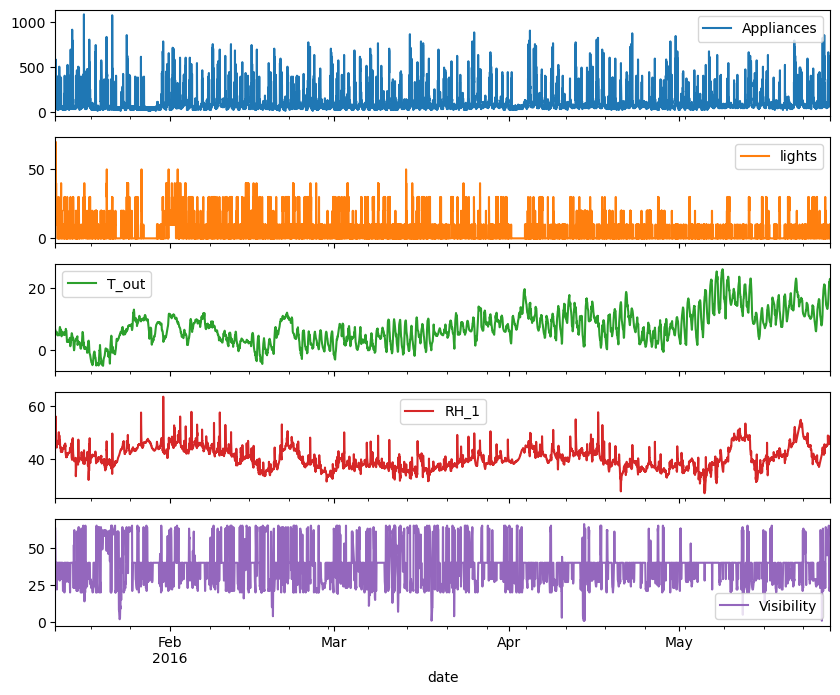

In [12]:
df.set_index('date')[['Appliances', 'lights', 'T_out', 'RH_1', 'Visibility']].plot(subplots=True)

In [14]:
df_input = df[['Appliances', 'T_out', 'RH_1', 'Visibility']]
df_input

,Appliances,T_out,RH_1,Visibility
0,60,6.600000,47.596667,63.000000
1,60,6.483333,46.693333,59.166667
2,50,6.366667,46.300000,55.333333
3,50,6.250000,46.066667,51.500000
4,60,6.133333,46.333333,47.666667
...,...,...,...,...
19730,100,22.733333,46.560000,23.666667
19731,90,22.600000,46.500000,24.500000
19732,270,22.466667,46.596667,25.333333
19733,420,22.333333,46.990000,26.166667


In [15]:
df_input.describe()

,Appliances,T_out,RH_1,Visibility
count,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,7.411665,40.259739,38.330834
std,102.524891,5.317409,3.979299,11.794719
min,10.000000,-5.000000,27.023333,1.000000
25%,50.000000,3.666667,37.333333,29.000000
50%,60.000000,6.916667,39.656667,40.000000
75%,100.000000,10.408333,43.066667,40.000000
max,1080.000000,26.100000,63.360000,66.000000


In [16]:
df_input.query('Appliances > 500')

,Appliances,T_out,RH_1,Visibility
11,580,5.983333,46.396667,40.000000
314,520,2.900000,41.530000,36.333333
392,550,2.033333,43.433333,40.000000
393,690,2.100000,43.766667,40.000000
394,620,2.166667,43.693333,40.000000
...,...,...,...,...
19586,600,20.833333,44.066667,40.000000
19587,520,20.900000,43.366667,40.000000
19684,580,15.900000,47.226667,61.000000
19685,660,16.100000,47.693333,61.000000


### Time to Start doing feature engineering 

We use a MinMaxScaler here.  In reality, we would fit_transform on the training data and then save the scaler to be used in the test data or data pipeline.  With the MinMaxScaler, any test data found outside of the range of the training data is going to go above 1 or below 0, which may or may not be a problem.  A RobustScaler may be the resolution to that or potentially applying a log transformation to the data first.

In [18]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_input)
data_scaled

array([[0.04672897, 0.37299035, 0.56618659, 0.95384615],
       [0.04672897, 0.36923901, 0.54132648, 0.89487179],
       [0.03738318, 0.36548767, 0.53050179, 0.83589744],
       ...,
       [0.24299065, 0.88317256, 0.53866618, 0.37435897],
       [0.38317757, 0.87888532, 0.54949087, 0.38717949],
       [0.39252336, 0.87459807, 0.53875791, 0.4       ]])

In [21]:
features = data_scaled
target = data_scaled[:,0]

array([0.04672897, 0.04672897, 0.03738318, ..., 0.24299065, 0.38317757,
       0.39252336])

#### Generate a time series from this.  ####
Essentially the next bit of code grabs 2 rows and we're predicting the target value for the next row.  This generate makes the training data sets of inputs and targets.

In [23]:
TimeseriesGenerator(features, target, length=2, sampling_rate=1, batch_size=1)[0]

(array([[[0.04672897, 0.37299035, 0.56618659, 0.95384615],
         [0.04672897, 0.36923901, 0.54132648, 0.89487179]]]),
 array([0.03738318]))

### Time to split the data to training and test.  ###
20% as Test, 80% as Training <br>
Shuffle = False because it is time series data and the order matters<br>
We do not pass time as a feature to an LSTM model.<br>

In [27]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=123, shuffle=False)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(15788, 4)
(3947, 4)
(15788,)
(3947,)


#### Define the actual time series generator ####

In [34]:
# win_length = 720 # 144 data points per day, 720 = 5 days of data;   720 was taking 7 minutes per training epoch. 
win_length = 144
batch_size = 32 
num_features=4
train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [35]:
train_generator[0]

(array([[[0.04672897, 0.37299035, 0.56618659, 0.95384615],
         [0.04672897, 0.36923901, 0.54132648, 0.89487179],
         [0.03738318, 0.36548767, 0.53050179, 0.83589744],
         ...,
         [0.02803738, 0.36655949, 0.45160994, 0.51538462],
         [0.02803738, 0.3676313 , 0.44417943, 0.48717949],
         [0.02803738, 0.36870311, 0.44051004, 0.45897436]],
 
        [[0.04672897, 0.36923901, 0.54132648, 0.89487179],
         [0.03738318, 0.36548767, 0.53050179, 0.83589744],
         [0.03738318, 0.36173633, 0.52408036, 0.77692308],
         ...,
         [0.02803738, 0.3676313 , 0.44417943, 0.48717949],
         [0.02803738, 0.36870311, 0.44051004, 0.45897436],
         [0.04672897, 0.36977492, 0.4350977 , 0.43076923]],
 
        [[0.03738318, 0.36548767, 0.53050179, 0.83589744],
         [0.03738318, 0.36173633, 0.52408036, 0.77692308],
         [0.04672897, 0.35798499, 0.53141914, 0.71794872],
         ...,
         [0.02803738, 0.36870311, 0.44051004, 0.45897436],
        

In [36]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(win_length, num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 144, 128)          68096     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 144, 128)          0         
                                                                 
 lstm_5 (LSTM)               (None, 144, 128)          131584    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 144, 128)          0         
                                                                 
 dropout_2 (Dropout)         (None, 144, 128)          0         
                                                                 
 lstm_6 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)               

In [38]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')

model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(),
              metrics=[tf.metrics.MeanAbsoluteError()])

history= model.fit_generator(train_generator, epochs=50, validation_data=test_generator,
                             shuffle=False,
                             callbacks=[early_stopping])

Epoch 1/50


C:\Users\JoeDavis\AppData\Local\Temp\ipykernel_24028\2892933759.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history= model.fit_generator(train_generator, epochs=50, validation_data=test_generator,


489/489 [==============================] - 93s 179ms/step - loss: 0.0086 - mean_absolute_error: 0.0518 - val_loss: 0.0052 - val_mean_absolute_error: 0.0456
Epoch 2/50
489/489 [==============================] - 86s 176ms/step - loss: 0.0064 - mean_absolute_error: 0.0418 - val_loss: 0.0037 - val_mean_absolute_error: 0.0369
Epoch 3/50
489/489 [==============================] - 87s 177ms/step - loss: 0.0045 - mean_absolute_error: 0.0337 - val_loss: 0.0031 - val_mean_absolute_error: 0.0308
Epoch 4/50
489/489 [==============================] - 87s 178ms/step - loss: 0.0042 - mean_absolute_error: 0.0322 - val_loss: 0.0030 - val_mean_absolute_error: 0.0285
Epoch 5/50
489/489 [==============================] - 88s 180ms/step - loss: 0.0041 - mean_absolute_error: 0.0316 - val_loss: 0.0030 - val_mean_absolute_error: 0.0292
Epoch 6/50
489/489 [==============================] - 87s 177ms/step - loss: 0.0041 - mean_absolute_error: 0.0316 - val_loss: 0.0030 - val_mean_absolute_error: 0.0279
Epoch 7/5

In [42]:
model.evaluate_generator(test_generator)

C:\Users\JoeDavis\AppData\Local\Temp\ipykernel_24028\2205837447.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator)


[0.002968244720250368, 0.028139114379882812]

In [40]:
predictions = model.predict_generator(test_generator)
print(predictions.shape)
predictions

C:\Users\JoeDavis\AppData\Local\Temp\ipykernel_24028\834749681.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator)


(3803, 1)


array([[0.04718227],
       [0.04934295],
       [0.05039868],
       ...,
       [0.09348954],
       [0.25986722],
       [0.2677896 ]], dtype=float32)

In [41]:
y_test

array([0.3364486 , 0.54205607, 0.28971963, ..., 0.24299065, 0.38317757,
       0.39252336])

In [43]:
x_test

array([[0.3364486 , 0.34297964, 0.30923768, 0.6       ],
       [0.54205607, 0.34726688, 0.3055683 , 0.6       ],
       [0.28971963, 0.35155413, 0.30455921, 0.6       ],
       ...,
       [0.24299065, 0.88317256, 0.53866618, 0.37435897],
       [0.38317757, 0.87888532, 0.54949087, 0.38717949],
       [0.39252336, 0.87459807, 0.53875791, 0.4       ]])

In [47]:
x_test[:,1:][win_length:]

array([[0.32475884, 0.3166682 , 0.77948718],
       [0.33762058, 0.32299789, 0.69230769],
       [0.35048232, 0.3193285 , 0.60512821],
       ...,
       [0.88317256, 0.53866618, 0.37435897],
       [0.87888532, 0.54949087, 0.38717949],
       [0.87459807, 0.53875791, 0.4       ]])

In [57]:
df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,1:][win_length:])], axis=1)
df_pred

,0,0,1,2
0,0.047182,0.324759,0.316668,0.779487
1,0.049343,0.337621,0.322998,0.692308
2,0.050399,0.350482,0.319329,0.605128
3,0.060420,0.363344,0.320338,0.517949
4,0.175193,0.376206,0.318319,0.430769
...,...,...,...,...
3798,0.092393,0.891747,0.537657,0.348718
3799,0.109048,0.887460,0.536006,0.361538
3800,0.093490,0.883173,0.538666,0.374359
3801,0.259867,0.878885,0.549491,0.387179


In [49]:
rev_trans = scaler.inverse_transform(df_pred)

In [50]:
rev_trans

array([[ 60.48502825,   5.1       ,  38.53      ,  51.66666667],
       [ 62.79695936,   5.5       ,  38.76      ,  46.        ],
       [ 63.92658502,   5.9       ,  38.62666667,  40.33333333],
       ...,
       [110.03380261,  22.46666667,  46.59666667,  25.33333333],
       [288.0579266 ,  22.33333333,  46.99      ,  26.16666667],
       [296.53487444,  22.2       ,  46.6       ,  27.        ]])

In [51]:
df_final = df_input[predictions.shape[0]*-1:]

In [52]:
df_final

,Appliances,T_out,RH_1,Visibility
15932,60,5.100000,38.530000,51.666667
15933,60,5.500000,38.760000,46.000000
15934,70,5.900000,38.626667,40.333333
15935,200,6.300000,38.663333,34.666667
15936,160,6.700000,38.590000,29.000000
...,...,...,...,...
19730,100,22.733333,46.560000,23.666667
19731,90,22.600000,46.500000,24.500000
19732,270,22.466667,46.596667,25.333333
19733,420,22.333333,46.990000,26.166667


In [53]:
df_final['App_Pred'] = rev_trans[:,0]

C:\Users\JoeDavis\AppData\Local\Temp\ipykernel_24028\3966257562.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['App_Pred'] = rev_trans[:,0]


In [54]:
df_final

,Appliances,T_out,RH_1,Visibility,App_Pred
15932,60,5.100000,38.530000,51.666667,60.485028
15933,60,5.500000,38.760000,46.000000,62.796959
15934,70,5.900000,38.626667,40.333333,63.926585
15935,200,6.300000,38.663333,34.666667,74.649395
15936,160,6.700000,38.590000,29.000000,197.456220
...,...,...,...,...,...
19730,100,22.733333,46.560000,23.666667,108.860298
19731,90,22.600000,46.500000,24.500000,126.681449
19732,270,22.466667,46.596667,25.333333,110.033803
19733,420,22.333333,46.990000,26.166667,288.057927


<Axes: >

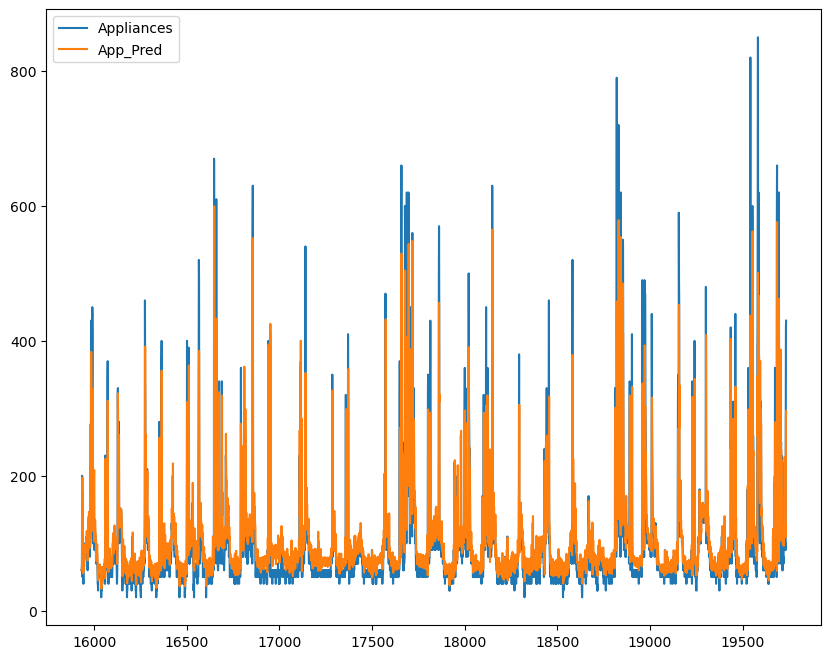

In [56]:
df_final[['Appliances', 'App_Pred']].plot()